In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress
import menzalib as mz

In [2]:
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def dlin_interp(x0,y0,x1,y1,const,errori):
    #errori=[dx0,dy0,dx1,dx2,dconst]
    x0+(x1-x0)*(const-y0)/(y0-y1)
    grad=[1-(const-y0)/(y0-y1),
         -(x1-x0)*((const-y0)/(y0-y1)+1)/(y0-y1),
         (const-y0)/(y0-y1),
         (x1-x0)*(const-y0)/(y0-y1)**2,
         (x1-x0)/(y0-y1)
          ]
    grad=np.array(grad)**2
    errori=np.array(errori)**2
    return np.sqrt(np.dot(grad,errori))


def intersection(x,y,const,dx=0,dy=0,dconst=0):
#finds the value of y for witch y=f(x) in couple of array x=[x_1,x_2,...,x_n] and y=[y_1,y_2,...,y_n]
    signs = np.sign(np.add(x, -const))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [[lin_interp(y, x, zero_crossing,const) for zero_crossing in zero_crossings_i],
    [dlin_interp(x[i],y[i],x[i+1],y[i+1],const,[dx[i],dy[i],dx[i+1],dy[i+1],dconst]) for i in zero_crossings_i]]


In [11]:
data = pd.read_csv('potenza_angolo.txt', sep="\t")
data=data.sort_values(by=['Angolo'])
ang,W,dW=np.transpose(data.values)
dW=dW+0.01
col1=mz.ns_tex(ang,1)
col2=mz.ne_tex(W,dW)
#mz.mat_tex([col1,col2])

In [81]:
def pearson(theta,theta0,Imax,w,m):
    return Imax*w**(2*m)/(w**2+(2**(1/m)-1)*(theta-theta0)**2)**m

def dpearson(theta,theta0,Imax,w,m):
    a=(2**(1/m)-1)
    b=-m*Imax*w**(2*m)*2*a*(theta-theta0)/(w**2+a*(theta-theta0)**2)**(m+1)
    return b

popt,pcov=mz.curve_fitdx(pearson,ang,W,p0=[-0.5,28,2,3],dy=dW,dx=1,df=dpearson)
print('Imax=',mz.ne_tex(popt[1],np.sqrt(pcov[0,0])))
x=np.linspace(ang[0],ang[-1],100)
y=pearson(x,*popt)

In [21]:
NA,dNA=intersection(W,ang,np.amax(W)/20,dW,np.ones(len(ang)),np.amax(dW)/20)
print('NA =',mz.ne_tex((NA[1]-NA[0])/2,np.sqrt(dNA[0]**2+dNA[1]**2)/2))

NA = $(1.8 \pm 0.2) \times 10^{1}$


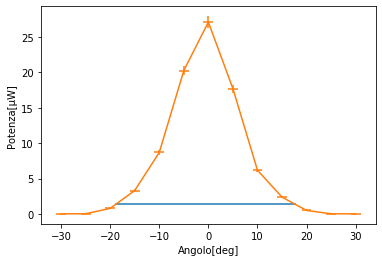

In [22]:
plt.plot(NA,np.amax(W)/20*np.array([1,1]))
plt.errorbar(ang,W,dW,1)
plt.ylabel('Potenza[μW]')
plt.xlabel('Angolo[deg]')
plt.savefig('potenza_angolo.eps',format='eps')
#plt.savefig('potenza_angolo.png')
#popt,pcov=curve_fit(pearson,ang,W,p0=[-0.5,28,2,3])


In [23]:
def fit(x,a,b):
    return a*x**(-4)+b

def att(Iin,Iout,L):
    return 10*np.log10(Iin/Iout)/L

def datt(Iin,dIin,Iout,dIout,L,dL):
    d1=np.log(Iin/Iout)*dL/L
    d2=dIin/(L*Iin)
    d3=dIout/(L*Iout)
    return 10*np.sqrt(d1**2+d2**2+d3**2)/np.log(10)

def att_con_err(Iin,dIin,Iout,dIout,L,dL):
    return att(Iin,Iout,L), datt(Iin,dIin,Iout,dIout,L,dL)


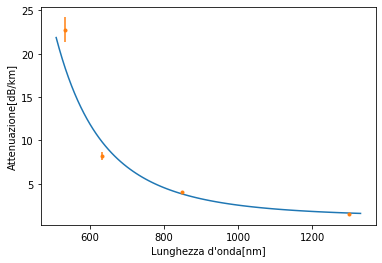

In [24]:
lung=[633,533,850,1300]
dI=0.1


Iin=[29.1,13]
dIin=[0.8,0.4]
Iout=[13.3,1.5]
dIout=[0.4,0.2]
L=[415e-3,412e-3]
dL=[1e-3,1e-3]


attHeNe,dattHeNe=att_con_err(Iin[0],dIin[0],Iout[0],dIout[0],L[0],dL[0])
attVerde,dattVerde=att_con_err(Iin[1],dIin[1],Iout[1],dIout[1],L[1],dL[1])
att=[attHeNe,attVerde,4,1.5]
datt=[dattHeNe,dattVerde,0.1,0.1]

x=[i**(-4) for i in lung]
popt=linregress(x,att)
popt=[popt[0],popt[1]]

popt,pcov=curve_fit(fit,lung,att,p0=popt,sigma=datt)

x=np.linspace(510,1330,100)
y=fit(x,*popt)
plt.plot(x,y)
plt.errorbar(lung,att,yerr=datt,fmt='.')
plt.xlabel('Lunghezza d\'onda[nm]')
plt.ylabel('Attenuazione[dB/km]')
plt.savefig('Rayleigh.eps',format='eps')

In [28]:
print(mz.ne_tex(attHeNe,dattHeNe))
print(mz.ne_tex(attVerde,dattVerde))
print('a viene uguale a',mz.ne_tex(popt[0],np.sqrt(pcov[0,0])))
print('b viene uguale a',mz.ne_tex(popt[1],np.sqrt(pcov[1,1])))

$8.2 \pm 0.4$
$(2.3 \pm 0.1) \times 10^{1}$
a viene uguale a $(1.4 \pm 0.2) \times 10^{12}$
b viene uguale a $1.1 \pm 0.4$
